#### Data Cleaning

In [ ]:
from IPython.display import display, HTML

# Use JavaScript to trigger kernel restart
display(HTML("<script>Jupyter.notebook.kernel.restart()</script>"))


In [1]:
import pandas as pd
import duckdb
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
db_path = '../../database/nsw_doe_data_case_study.duckdb'
con = duckdb.connect(db_path)
con.execute("CREATE TABLE student_attendance_data AS SELECT * FROM read_csv_auto('../../data/attendance_data.csv');")
con.commit()
# Close the connection.
con.close()

In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=True)
results = con.execute("SELECT * FROM multi_age_composite_dataset LIMIT 10").fetchall()
print(results)


In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=True)
table_list = con.execute("SHOW TABLES").fetchall()
print(table_list)


In [ ]:
# Define constants
years = ['14', '15', '16', '17', '18', '19', '21', '22']
measures = ['COMPOSITE_CLASS_COUNT', 'COMPOSITE_CLASS_STUDENTS', 'PCT_COMPOSITE_CLASSES', 'PCT_COMPOSITE_CLASS_STUDENTS']
# Flatten the table
flattened_queries = []
for year in years:
    year_cols = [f"{measure}_{year} AS {measure}" for measure in measures]
    query = f"""
    SELECT 
        School_code,
        School_Name,
        '20{year}' AS Year,
        {', '.join(year_cols)}
    FROM multi_age_composite_dataset
    """
    flattened_queries.append(query)
final_flattened_query = "\nUNION ALL\n".join(flattened_queries)
con.execute(f"CREATE TABLE multi_age_composite_unpivoted AS {final_flattened_query}")

In [ ]:
import duckdb
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb')
columns = con.execute("PRAGMA table_info(student_attendance_dataset)").fetchall()
year_columns = [str(row[1]) for row in columns if row[1].isdigit()]
sql_parts = []
for year in year_columns:
    sql_part = f"""
    SELECT 
        school_code AS School_Code,
        school_name AS School_Name,
        '{year}' AS Year,
        "{year}" AS Attendance_pct
    FROM student_attendance_dataset
    """
    sql_parts.append(sql_part)
sql_command = "\nUNION ALL\n".join(sql_parts)
con.execute(f"CREATE TABLE student_attendance_unpivoted AS {sql_command}")
con.close()

In [ ]:
# Establish a connection
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb', read_only=False)
query = """
ALTER TABLE unpivoted_dataset RENAME TO multi_age_composite_unpivoted;
"""
con.execute(query)
# Close the connection
con.close()

In [ ]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)
df = con.sql('select * from multi_age_composite_unpivoted').df()
print(df.shape)
df.head()


In [ ]:
con.close()

In [ ]:
query = "SELECT * FROM public_school_nsw_master_dataset"
df = con.execute(query).fetchdf()  # Use fetchdf() to get a DataFrame
# Save the DataFrame to Excel
excel_path = "public_school_nsw_master_dataset.xlsx"
df.to_excel(excel_path, index=False, engine='openpyxl')

#### Missing Value Statistics

In [ ]:
# Step 1: Connect to the database
con.close()
database_path = '../../database/nsw_doe_data_case_study.duckdb'
database_connection = duckdb.connect(database_path, read_only=False)
# Step 2: Define a function that calculates and shows missing data
def get_missing_data_info(data_frame):
    # Count how many missing values there are
    missing_count = data_frame.isnull().sum()
        # Find out the percentage of missing values
    missing_percentage = (missing_count / len(data_frame)) * 100
        # Put our results in a table and return it
    result_table = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percentage
    })
    # Sorting the results to make it more readable
    result_table = result_table.sort_values(by='Missing %', ascending=False)
    return result_table
# Step 3: Get data from the database
data_from_public_schools = database_connection.execute("SELECT * FROM public_school_nsw_master_dataset").fetchdf()
data_from_multi_age = database_connection.execute("SELECT * FROM multi_age_composite_unpivoted").fetchdf()
data_from_attendance = database_connection.execute("SELECT * FROM student_attendance_unpivoted").fetchdf()
# Step 4: Use our function on the data and print the results
print("Info on Missing Data in public_school_nsw_master_dataset")
print(get_missing_data_info(data_from_public_schools))
print("------\n")

print("Info on Missing Data in multi_age_composite_unpivoted")
print(get_missing_data_info(data_from_multi_age))
print("------\n")

print("Info on Missing Data in student_attendance_unpivoted")
print(get_missing_data_info(data_from_attendance))
print("------\n")


##### Missing value imputation

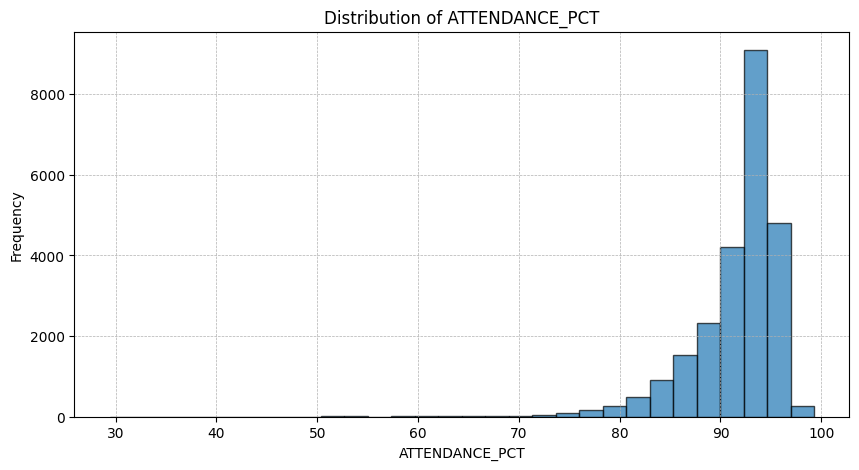

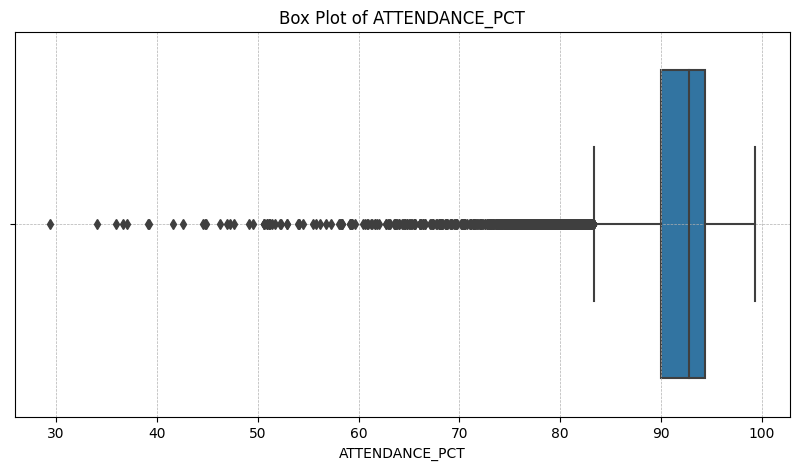

In [6]:
con = duckdb.connect('../../database/nsw_doe_data_case_study.duckdb',read_only=False)
attendance_data = con.execute("SELECT ATTENDANCE_PCT FROM STUDENT_ATTENDANCE_UNPIVOTED").fetchdf()
# Convert 'na' and other non-numeric entries to NaN for visualization
attendance_data['ATTENDANCE_PCT'] = pd.to_numeric(attendance_data['ATTENDANCE_PCT'], errors='coerce')
# Plot histogram for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
plt.hist(attendance_data['ATTENDANCE_PCT'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of ATTENDANCE_PCT')
plt.xlabel('ATTENDANCE_PCT')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plotting box plot for ATTENDANCE_PCT
plt.figure(figsize=(10, 5))
sns.boxplot(x=attendance_data['ATTENDANCE_PCT'])
plt.title('Box Plot of ATTENDANCE_PCT')
plt.xlabel('ATTENDANCE_PCT')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [4]:
# Iterate through the DataFrame and update NULL values in the database
for index, row in attendance_data.iterrows():
    if pd.isnull(row['ATTENDANCE_PCT']):
        con.execute(f"UPDATE STUDENT_ATTENDANCE_UNPIVOTED SET ATTENDANCE_PCT = {median_value} WHERE School_Code = {row['School_Code']} AND Year = {row['Year']}")
# Commit the changes and close the connection
con.commit()
con.close()
# Convert any 'NULL' values to numpy's NaN for compatibility with pandas
attendance_data.replace('NULL', np.nan, inplace=True)
# Impute the missing values with the median
median_value = attendance_data['ATTENDANCE_PCT'].median()
attendance_data['ATTENDANCE_PCT'].fillna(median_value, inplace=True)
# Check if there are still any missing values left
missing_values = attendance_data['ATTENDANCE_PCT'].isnull().sum()
print(f"There are {missing_values} missing values in the ATTENDANCE_PCT column.")

There are 0 missing values in the ATTENDANCE_PCT column.
